In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
from pprint import pprint
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid', {'axes.edgecolor': '.2'})
sns.set_context('notebook', font_scale=1.4)

from fairlearn.datasets import fetch_acs_income

# Get Data
- downsample by just focusing on one state for this project

In [3]:
output = fetch_acs_income(cache=True, data_home=None,
                          as_frame=True, return_X_y=True,
                          states=['MA'],
                         )
X, y = output
X['PINCP'] = y
X

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,PINCP
708632,18.0,1.0,18.0,5.0,2330.0,36.0,17.0,7.0,2.0,9.0,3000.0
708633,28.0,1.0,21.0,5.0,4251.0,25.0,17.0,60.0,1.0,1.0,35000.0
708634,22.0,1.0,19.0,5.0,2205.0,6.0,17.0,25.0,1.0,1.0,4000.0
708635,18.0,1.0,18.0,5.0,4700.0,36.0,17.0,50.0,1.0,1.0,12000.0
708636,20.0,3.0,19.0,5.0,7640.0,25.0,17.0,40.0,1.0,1.0,5000.0
...,...,...,...,...,...,...,...,...,...,...,...
748741,21.0,2.0,19.0,5.0,3603.0,25.0,2.0,15.0,2.0,1.0,15600.0
748742,47.0,1.0,21.0,1.0,1022.0,25.0,0.0,40.0,2.0,1.0,72000.0
748743,46.0,1.0,21.0,1.0,20.0,25.0,1.0,50.0,1.0,1.0,150000.0
748744,36.0,1.0,22.0,1.0,440.0,25.0,0.0,40.0,2.0,1.0,78000.0


Examine the data

In [4]:
# no N/A values
X.isna().sum()

AGEP     0
COW      0
SCHL     0
MAR      0
OCCP     0
POBP     0
RELP     0
WKHP     0
SEX      0
RAC1P    0
PINCP    0
dtype: int64

In [5]:
# all are float or int
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40114 entries, 708632 to 748745
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGEP    40114 non-null  float64
 1   COW     40114 non-null  float64
 2   SCHL    40114 non-null  float64
 3   MAR     40114 non-null  float64
 4   OCCP    40114 non-null  float64
 5   POBP    40114 non-null  float64
 6   RELP    40114 non-null  float64
 7   WKHP    40114 non-null  float64
 8   SEX     40114 non-null  float64
 9   RAC1P   40114 non-null  float64
 10  PINCP   40114 non-null  float64
dtypes: float64(11)
memory usage: 3.7 MB


# Preprocssing 
- 8 of the 10 features are floats but they must be treated as categorical when training the model

- For the scope of this project, the features will also be downsampled to only use AGEP, WKHP, SCHL, SEX, OCCP, and MAR

- Some features have many categories that are also somewhat sparse since some of the categories have very few examples. So let's just bin those together to give the tree algorithm a better chance

In [6]:
acs_income_cat = X.copy(deep=True)
# drop columns
acs_income_cat = acs_income_cat.drop(['COW', 'POBP', 'RELP', 'RAC1P'], axis=1)
acs_income_cat

,AGEP,SCHL,MAR,OCCP,WKHP,SEX,PINCP
708632,18.0,18.0,5.0,2330.0,7.0,2.0,3000.0
708633,28.0,21.0,5.0,4251.0,60.0,1.0,35000.0
708634,22.0,19.0,5.0,2205.0,25.0,1.0,4000.0
708635,18.0,18.0,5.0,4700.0,50.0,1.0,12000.0
708636,20.0,19.0,5.0,7640.0,40.0,1.0,5000.0
...,...,...,...,...,...,...,...
748741,21.0,19.0,5.0,3603.0,15.0,2.0,15600.0
748742,47.0,21.0,1.0,1022.0,40.0,2.0,72000.0
748743,46.0,21.0,1.0,20.0,50.0,1.0,150000.0
748744,36.0,22.0,1.0,440.0,40.0,2.0,78000.0


# Sex

In [7]:
acs_income_cat.SEX.replace(1, 'Male', inplace=True)
acs_income_cat.SEX.replace(2, 'Female', inplace=True)
acs_income_cat

,AGEP,SCHL,MAR,OCCP,WKHP,SEX,PINCP
708632,18.0,18.0,5.0,2330.0,7.0,Female,3000.0
708633,28.0,21.0,5.0,4251.0,60.0,Male,35000.0
708634,22.0,19.0,5.0,2205.0,25.0,Male,4000.0
708635,18.0,18.0,5.0,4700.0,50.0,Male,12000.0
708636,20.0,19.0,5.0,7640.0,40.0,Male,5000.0
...,...,...,...,...,...,...,...
748741,21.0,19.0,5.0,3603.0,15.0,Female,15600.0
748742,47.0,21.0,1.0,1022.0,40.0,Female,72000.0
748743,46.0,21.0,1.0,20.0,50.0,Male,150000.0
748744,36.0,22.0,1.0,440.0,40.0,Female,78000.0


## MAR: maritial status
- ranges from 1 to 5
- individually, the categories 2 (widowed) and 4 (separated) are very small so this leads to sparse features. Could potentially lump these into the same "other" category, but we'll save that for future work

{1.0: 20715, 2.0: 697, 3.0: 3630, 4.0: 546, 5.0: 14526}


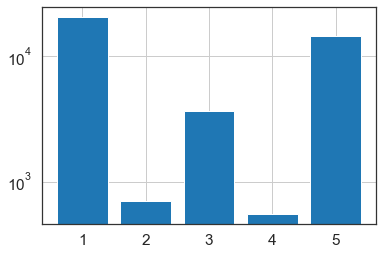

In [8]:
values, counts = np.unique(acs_income_cat.MAR.values, return_counts=True)
d_tmp = {v: c for v,c in zip(values, counts)}
pprint(d_tmp)
plt.bar(values, counts)
plt.yscale('log')

In [9]:
for i, c in enumerate(counts):
    # categories start at index 1. but Python is index 0
    print(f'{i+1:02}', f'{c / counts.sum()*100:5.2f}%')

01 51.64%
02  1.74%
03  9.05%
04  1.36%
05 36.21%


Use codes from data dictionary: https://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2018.pdf

In [10]:
MAR_dict = {1: 'Married',
            2: 'Widowed',
            3: 'Divorced',
            4: 'Separated',
            5: 'Never_Married',
           }
for key, value in MAR_dict.items():
    acs_income_cat.MAR.replace(key, value, inplace=True)
acs_income_cat

,AGEP,SCHL,MAR,OCCP,WKHP,SEX,PINCP
708632,18.0,18.0,Never_Married,2330.0,7.0,Female,3000.0
708633,28.0,21.0,Never_Married,4251.0,60.0,Male,35000.0
708634,22.0,19.0,Never_Married,2205.0,25.0,Male,4000.0
708635,18.0,18.0,Never_Married,4700.0,50.0,Male,12000.0
708636,20.0,19.0,Never_Married,7640.0,40.0,Male,5000.0
...,...,...,...,...,...,...,...
748741,21.0,19.0,Never_Married,3603.0,15.0,Female,15600.0
748742,47.0,21.0,Married,1022.0,40.0,Female,72000.0
748743,46.0,21.0,Married,20.0,50.0,Male,150000.0
748744,36.0,22.0,Married,440.0,40.0,Female,78000.0


## SCHL (Educational attainment)
- ranges from 1 to 24 but the first 15 are just education is below high school diploma, which are very sparse so just group these together
- Use codes from data dictionary: https://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2018.pdf

{1.0: 301,
 2.0: 3,
 3.0: 6,
 4.0: 13,
 5.0: 8,
 6.0: 19,
 7.0: 41,
 8.0: 45,
 9.0: 83,
 10.0: 55,
 11.0: 127,
 12.0: 184,
 13.0: 345,
 14.0: 687,
 15.0: 465,
 16.0: 6757,
 17.0: 860,
 18.0: 2324,
 19.0: 5227,
 20.0: 2858,
 21.0: 10910,
 22.0: 6004,
 23.0: 1425,
 24.0: 1367}


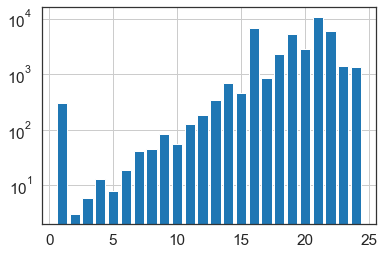

In [11]:
values, counts = np.unique(acs_income_cat.SCHL.values, return_counts=True)
d_tmp = {v: c for v,c in zip(values, counts)}
pprint(d_tmp)
plt.bar(values, counts)
plt.yscale('log')

In [12]:
# everything under category 16 is 1% or much much less so just lump that together
for i, c in enumerate(counts):
    # categories start at index 1. but Python is index 0
    print(f'{i+1:02}', f'{c / counts.sum()*100:5.2f}%')

01  0.75%
02  0.01%
03  0.01%
04  0.03%
05  0.02%
06  0.05%
07  0.10%
08  0.11%
09  0.21%
10  0.14%
11  0.32%
12  0.46%
13  0.86%
14  1.71%
15  1.16%
16 16.84%
17  2.14%
18  5.79%
19 13.03%
20  7.12%
21 27.20%
22 14.97%
23  3.55%
24  3.41%


In [13]:
# 94% fall in the last categories
# categories start at index 1. but Python is index 0. so index 16 onwards is 15 in python
counts[15:].sum() / counts.sum()

0.9406192351797378

In [14]:
# lump the first 15 categories (i.e. haven't graduated high school) into one category
SCHL_dict = {i: 'SCHL1-15' for i in range(1,16) }
SCHL_dict.update({i: f'SCHL{i}' for i in range(16,25)})
for key, value in SCHL_dict.items():
    acs_income_cat.SCHL.replace(key, value, inplace=True)
acs_income_cat

,AGEP,SCHL,MAR,OCCP,WKHP,SEX,PINCP
708632,18.0,SCHL18,Never_Married,2330.0,7.0,Female,3000.0
708633,28.0,SCHL21,Never_Married,4251.0,60.0,Male,35000.0
708634,22.0,SCHL19,Never_Married,2205.0,25.0,Male,4000.0
708635,18.0,SCHL18,Never_Married,4700.0,50.0,Male,12000.0
708636,20.0,SCHL19,Never_Married,7640.0,40.0,Male,5000.0
...,...,...,...,...,...,...,...
748741,21.0,SCHL19,Never_Married,3603.0,15.0,Female,15600.0
748742,47.0,SCHL21,Married,1022.0,40.0,Female,72000.0
748743,46.0,SCHL21,Married,20.0,50.0,Male,150000.0
748744,36.0,SCHL22,Married,440.0,40.0,Female,78000.0


In [15]:
acs_income_cat.SCHL.unique().shape

(10,)

# OCCP
- Group by the first 3 letters of the occupation code
- Purpose is to condense from 530 categories to 26 categories

In [16]:
values, counts = np.unique(acs_income_cat.OCCP.values, return_counts=True)
d_tmp = {v: c for v,c in zip(values, counts)}
# 518 categories
len(counts)

518

Copy the values from the data dictionary: https://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2018.pdf
I changed this file so that 
- 1555 was .ENG-Other Engineering Technologists And Technicians, Except Drafters. Previously it had no ENG-
- 8000 was .PRD-Grinding, Lapping, Polishing, And Buffing Machine Tool. previously, it had no PRD-

In [17]:
abbreviations = []
categories = {}
with open('OCCP_categories.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        abbreviation = line.split('.')[1].split('-')[0]
        abbreviations.append(abbreviation)
        
        code = int(line.split()[0])
        if abbreviation in categories.keys():
            categories[abbreviation].append(code)
        else:
            categories[abbreviation] = [code]
len(abbreviations)

530

In [18]:
len(categories.keys())

26

In [19]:
for key, value in categories.items():
    for val in value:
        acs_income_cat.OCCP.replace(val, key, inplace=True)
acs_income_cat

,AGEP,SCHL,MAR,OCCP,WKHP,SEX,PINCP
708632,18.0,SCHL18,Never_Married,EDU,7.0,Female,3000.0
708633,28.0,SCHL21,Never_Married,CLN,60.0,Male,35000.0
708634,22.0,SCHL19,Never_Married,EDU,25.0,Male,4000.0
708635,18.0,SCHL18,Never_Married,SAL,50.0,Male,12000.0
708636,20.0,SCHL19,Never_Married,RPR,40.0,Male,5000.0
...,...,...,...,...,...,...,...
748741,21.0,SCHL19,Never_Married,HLS,15.0,Female,15600.0
748742,47.0,SCHL21,Married,CMM,40.0,Female,72000.0
748743,46.0,SCHL21,Married,MGR,50.0,Male,150000.0
748744,36.0,SCHL22,Married,MGR,40.0,Female,78000.0


In [20]:
# great, no N/A values
acs_income_cat.isna().sum()

AGEP     0
SCHL     0
MAR      0
OCCP     0
WKHP     0
SEX      0
PINCP    0
dtype: int64

In [21]:
acs_income_cat.to_csv('2018_ACSIncome_MA_categories.csv', index=False)

# Create a second df with numerical categories starting from 0

- if using LightGBM, categorical features must be encoded as non-negative integers (int) less than Int32.MaxValue (2147483647). It is best to use a contiguous range of integers started from zero.
https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html

In [22]:
acs_income_cat_int = acs_income_cat.copy(deep=True)

In [23]:
# sex
sex_dict = {'Male': 0,
            'Female': 1
           }
for key, value in sex_dict.items():
    acs_income_cat_int.SEX.replace(key, value, inplace=True)
acs_income_cat_int

,AGEP,SCHL,MAR,OCCP,WKHP,SEX,PINCP
708632,18.0,SCHL18,Never_Married,EDU,7.0,1,3000.0
708633,28.0,SCHL21,Never_Married,CLN,60.0,0,35000.0
708634,22.0,SCHL19,Never_Married,EDU,25.0,0,4000.0
708635,18.0,SCHL18,Never_Married,SAL,50.0,0,12000.0
708636,20.0,SCHL19,Never_Married,RPR,40.0,0,5000.0
...,...,...,...,...,...,...,...
748741,21.0,SCHL19,Never_Married,HLS,15.0,1,15600.0
748742,47.0,SCHL21,Married,CMM,40.0,1,72000.0
748743,46.0,SCHL21,Married,MGR,50.0,0,150000.0
748744,36.0,SCHL22,Married,MGR,40.0,1,78000.0


In [24]:
# schl
categories = acs_income_cat_int.SCHL.unique()
categories.sort()
schl_dict = {cat: i for i, cat in enumerate(categories)}
pprint(schl_dict)
for key, value in schl_dict.items():
    acs_income_cat_int.SCHL.replace(key, value, inplace=True)
acs_income_cat_int

{'SCHL1-15': 0,
 'SCHL16': 1,
 'SCHL17': 2,
 'SCHL18': 3,
 'SCHL19': 4,
 'SCHL20': 5,
 'SCHL21': 6,
 'SCHL22': 7,
 'SCHL23': 8,
 'SCHL24': 9}


,AGEP,SCHL,MAR,OCCP,WKHP,SEX,PINCP
708632,18.0,3,Never_Married,EDU,7.0,1,3000.0
708633,28.0,6,Never_Married,CLN,60.0,0,35000.0
708634,22.0,4,Never_Married,EDU,25.0,0,4000.0
708635,18.0,3,Never_Married,SAL,50.0,0,12000.0
708636,20.0,4,Never_Married,RPR,40.0,0,5000.0
...,...,...,...,...,...,...,...
748741,21.0,4,Never_Married,HLS,15.0,1,15600.0
748742,47.0,6,Married,CMM,40.0,1,72000.0
748743,46.0,6,Married,MGR,50.0,0,150000.0
748744,36.0,7,Married,MGR,40.0,1,78000.0


In [25]:
# mar
mar_dict = {'Married': 0,
            'Widowed': 1,
            'Divorced': 2,
            'Separated': 4,
            'Never_Married': 5,
           }
for key, value in mar_dict.items():
    acs_income_cat_int.MAR.replace(key, value, inplace=True)
acs_income_cat_int

,AGEP,SCHL,MAR,OCCP,WKHP,SEX,PINCP
708632,18.0,3,5,EDU,7.0,1,3000.0
708633,28.0,6,5,CLN,60.0,0,35000.0
708634,22.0,4,5,EDU,25.0,0,4000.0
708635,18.0,3,5,SAL,50.0,0,12000.0
708636,20.0,4,5,RPR,40.0,0,5000.0
...,...,...,...,...,...,...,...
748741,21.0,4,5,HLS,15.0,1,15600.0
748742,47.0,6,0,CMM,40.0,1,72000.0
748743,46.0,6,0,MGR,50.0,0,150000.0
748744,36.0,7,0,MGR,40.0,1,78000.0


In [26]:
# occp
categories = acs_income_cat_int.OCCP.unique()
categories.sort()
occp_dict = {cat: i for i, cat in enumerate(categories)}
pprint(occp_dict)
for key, value in occp_dict.items():
    acs_income_cat_int.OCCP.replace(key, value, inplace=True)
acs_income_cat_int

{'BUS': 0,
 'CLN': 1,
 'CMM': 2,
 'CMS': 3,
 'CON': 4,
 'EAT': 5,
 'EDU': 6,
 'ENG': 7,
 'ENT': 8,
 'EXT': 9,
 'FFF': 10,
 'FIN': 11,
 'HLS': 12,
 'LGL': 13,
 'MED': 14,
 'MGR': 15,
 'MIL': 16,
 'OFF': 17,
 'PRD': 18,
 'PRS': 19,
 'PRT': 20,
 'RPR': 21,
 'SAL': 22,
 'SCI': 23,
 'TRN': 24}


,AGEP,SCHL,MAR,OCCP,WKHP,SEX,PINCP
708632,18.0,3,5,6,7.0,1,3000.0
708633,28.0,6,5,1,60.0,0,35000.0
708634,22.0,4,5,6,25.0,0,4000.0
708635,18.0,3,5,22,50.0,0,12000.0
708636,20.0,4,5,21,40.0,0,5000.0
...,...,...,...,...,...,...,...
748741,21.0,4,5,12,15.0,1,15600.0
748742,47.0,6,0,2,40.0,1,72000.0
748743,46.0,6,0,15,50.0,0,150000.0
748744,36.0,7,0,15,40.0,1,78000.0


In [27]:
acs_income_cat_int.to_csv('2018_ACSIncome_MA_int_categories.csv', index=False)